# Spatial entropy of cell (cold local minima) location configurations in IR
For evolutionary theory paper 

In [655]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob 

In [794]:
datadirs = glob('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/*') 
datadirs

['/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels',
 '/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations_5timelevels',
 '/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater',
 '/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_1yearlater']

In [805]:
cases = ['Amaz','SPCZ','Amaz+1y','SPCZ+1y']
nfiles = []
for idir in datadirs: 
    fpaths = glob(idir+'/*') 
    print(len(fpaths)) 
    nfiles.append(len(fpaths))

235
141
235
141


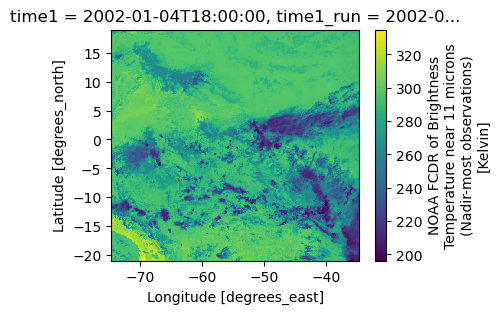

In [660]:
ds = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater/Amz_23Z_2001-01-04_12hleadup+YEAR.nc' ) #, combine='nested', concat_dim='case') 
#ds = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_1yearlater/SPCZ_09Z_2009-06-08_12hleadup+YEAR.nc' ) #, combine='nested', concat_dim='case') 

ds.irwin_cdr[2].plot(size=3);

In [661]:
# Amazon and SPCZ UTC values (LST daytime, 15h), for plot labels later 
SUTCs = np.array([21,  0,  3,  6,  9])
AUTCs = (SUTCs + 14) % 24
AUTCs

array([11, 14, 17, 20, 23])

# Definition for cell locations: minima colder than threshold 

In [662]:
from scipy.ndimage import gaussian_filter, minimum_filter

def find_local_minima(data, sigma=1.0, neighborhood_size=3):
    # Find local minima using a minimum filter
    minima = data == minimum_filter(data, footprint=np.ones((neighborhood_size, neighborhood_size)))
    return minima

def smooth_array(data, sigma=1.0):
    smoothed_data = gaussian_filter(data, sigma=sigma)
    return smoothed_data

In [663]:
# Utility for a coastline() function for quick plots 
DEM05 = xr.open_dataset('./DEM.halfdeg.nc')

#lon fixer: #DEM05 = DEM05.roll(lon=(DEM05.sizes['lon'] // 2)) #DEM05['lon'] = (DEM05['lon'] + 180) % 360
def coastline(**kwargs): 
    DEM05.z.plot.contour(vmin=0, vmax=0.01, **kwargs)

# Trehshold -40C (ice), Gaussian smoother sigma=1.0

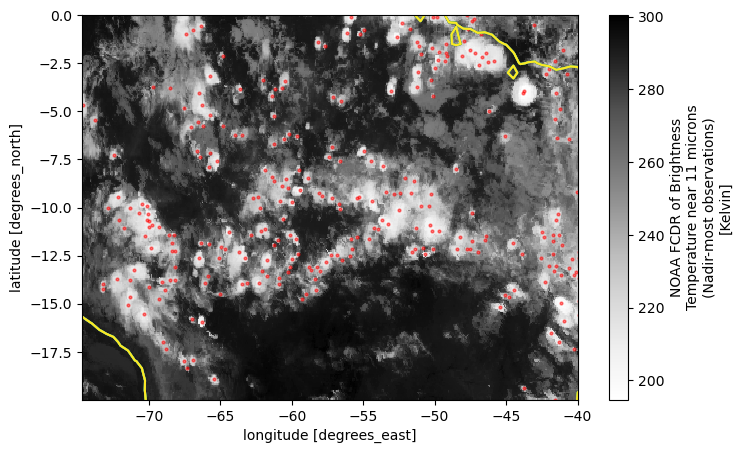

In [664]:
# TEST IMAGE and minima
IRTHRESHOLD = 273-40 

image = ds.irwin_cdr[4]
minima = find_local_minima( smooth_array(image, sigma=1) )
coldminima = minima & (image.values < IRTHRESHOLD)
cells = np.where(coldminima) # tuple of locations, y in [0] and x in [1] oddly

# Slice lat to -20,15
image.sel(lat=slice(-20,0),lon=slice(-80,-40)).plot(cmap='Greys', size=5, aspect=1.6)
#image.sel(lat=slice(-20,15),lon=slice(-80,-30)).plot(cmap='Greys', size=5, aspect=1.5)
plt.scatter( ds.lon[cells[1]] , ds.lat[cells[0]], c='red', alpha=0.5, s=4 );
coastline()

# Composite of probability, by distance from cells

numpy.pad(array, pad_width, mode='constant', **kwargs) 

In [ ]:
# TEST ON ONE TIME LEVEL 
# Loop over locations, roll the array, and tally the sum of a categorical (0 or 1) array

padded = np.pad(coldminima, 100)

composite_sum = padded*0.0
composite_num = 0.0   # no need for array like int(ccold.values *0) unless there are missing data 

# Locations to center the composite around 
i_vals, j_vals = np.where(padded) 
NX,NY = padded.shape
halfNX = int(NX/2); halfNY = int(NY/2)

# Loop over locations, roll the array, and tally the sum 
for active in range( len(i_vals) ):
    rolled = np.roll(padded, (halfNX-i_vals[active], halfNY-j_vals[active]), axis=(0, 1))
    composite_sum += rolled
    composite_num += 1.0 

# Final result:
composite = composite_sum / composite_num

# Plot it: 
plt.pcolormesh( np.log10(composite + 1e-99), vmin=-4, vmax=-2 ); plt.colorbar(); 
plt.title('log of probability with distance') 

In [809]:
fpath = fpaths[0]
fname = fpath.replace(dir,'') # extract the path, to give filename only 
fname[:2]

'SP'

# Looping over all cases and times 

In [ ]:
# THE BIG SLOW LOOP 
# loop over all filenames and sum up the frequency of categorical (0 or 1) arrays

NCELLS = np.ones( (4,5,250) )*0  # time series of ncells for possible weather screening
NCELLS2= np.ones( (4,5,250) )*0  # time series of ncells for possible weather screening

IRTHRESHOLD = 273-40 

results   = np.ones( (4,5,5,286,286) ) # central 286x286 box of composite space, for all 5 times of day, with basetimes [0,4], for all 4 cases
results2  = np.ones( (4,5,5,286,286) ) # one year earlier or later! Same climatology, decoupled from cell 

for idir,dir in enumerate(datadirs[:2]):  # MCS year only (0 and 1 directories)
    print('working on cases in ', dir)
    fpaths = glob(dir+'/*') 
    for ifile,fpath in enumerate(fpaths): 
        fname = fpath.replace(dir,'') # extract the path, to give filename only 
        fname2= fname[:-3]
        ds = xr.open_dataset(fpath) 

# Open the file one year later as ds2 
        fpath2 = datadirs[idir+2] + fname[:-3] + '+YEAR.nc'
        ds2= xr.open_dataset( fpath2 )
        print(fname, fpath2) 

        
############### FOR ds THE MAIN MCS YEAR 
        IR286 = ds.irwin_cdr.sel( lat=slice(-20,0)    ,lon=slice(-160.5,-140.5) )
        if (IR286.lon.size == 0): 
            IR286 = ds.irwin_cdr.sel( lat=slice(-19.8,0.21),lon=slice(-65,-45) )
        if( (IR286.lat.size != 286) or (IR286.lon.size != 286)  ): 
            print('weird case idir,ifile ', idir,ifile, fpath)
        
# 5,286,286 container for the Boolean cell arrays 
        coldminima = IR286.values*0.0      
        
# Fill the coldminima arrays for each time, from transforming IR286 (a cell finding algorithm) 
        for itime in range(NT):
            image = IR286[itime]
            minima = find_local_minima( smooth_array(image, sigma=1) )
            cell_yesno = minima & (image < IRTHRESHOLD)
            coldminima[itime,:,:] = cell_yesno  
            NCELLS[idir,itime,ifile] = np.sum(cell_yesno.values)



############### FOR ds2 THE CORRESPONDING DAY 1 YEAR LATER
        IR286 = ds2.irwin_cdr.sel( lat=slice(-20,0)    ,lon=slice(-160.5,-140.5) )
        if (IR286.lon.size == 0): 
            IR286 = ds2.irwin_cdr.sel( lat=slice(-19.8,0.21),lon=slice(-65,-45) )
        if( (IR286.lat.size != 286) or (IR286.lon.size != 286)  ): 
            print('weird case idir,ifile ', idir,ifile, fpath2)
        
# 5,286,286 container for the Boolean cell arrays 
        coldminima2 = IR286.values*0.0      
        
# Fill the coldminima arrays for each time, from transforming IR286 (a cell finding algorithm) 
        for itime in range(NT):
            image = IR286[itime]
            minima = find_local_minima( smooth_array(image, sigma=1) )
            cell_yesno = minima & (image < IRTHRESHOLD)
            coldminima2[itime,:,:] = cell_yesno  
            NCELLS2[idir,itime,ifile] = np.sum(cell_yesno.values)
        
            
# Padding around horizontal edges, and set up to adjust centerpoint with halfNX and halfNY
        pad_cells = np.pad(coldminima , ((0,0),(143,143),(143,143)) )
        pad_cells2= np.pad(coldminima2, ((0,0),(143,143),(143,143)) )


################ OK we have coldminima and coldminima2, and padded versions.
# We can make the same-year composites (results), and cross-year (results2)
        NX,NY = pad_cells[0,:,:].shape
        halfNX = int(NX/2); halfNY = int(NY/2)
        
# Begin composite building: loop over all the basetimes 
        for ibase,basetime in enumerate( range(NT) ):  
# Locations to center the composite around: "cells" in an "image" drawn from unpadded IR286
            i_vals, j_vals = np.where( pad_cells [basetime,:,:] ) # locations of all "cells" (coldminima ==True)
            i_vals2,j_vals2= np.where( pad_cells2[basetime,:,:] ) # locations of all "cells" (coldminima2 ==True)

            
# Loop over For i_vals in MCS year. Roll the padded data for all 5 time levels at once. 
            for cell in range( len(i_vals) ):       
                # for the MCS year (cells in same year as central conditional cell)
                rolled = np.roll(pad_cells , (0, halfNX-i_vals[cell], halfNY-j_vals[cell]), axis=(0,1,2) )
                results[idir, ibase, :,:,:] +=  rolled[:,halfNX-143:halfNX+143, halfNY-143:halfNY+143]

                # for the +1 year (cells in other year from central composite cell)
                rolled = np.roll(pad_cells2, (0, halfNX-i_vals[cell], halfNY-j_vals[cell]), axis=(0,1,2) )
                results2[idir, ibase, :,:,:] +=  rolled[:,halfNX-143:halfNX+143, halfNY-143:halfNY+143]

            
# Loop over For i_vals2 (the YEAR+1 cells). Roll the padded data for all 5 time levels at once.  
            for cell in range( len(i_vals2) ):       
                # for the SAME year (here the +1 year, pad_cells2 arreay and ivals2 index
                rolled = np.roll(pad_cells2 , (0, halfNX-i_vals2[cell], halfNY-j_vals2[cell]), axis=(0,1,2) )
                results[idir, ibase, :,:,:] +=  rolled[:,halfNX-143:halfNX+143, halfNY-143:halfNY+143]
                # for the OTHER year (here the MCS year, pad_cells and ivals index
                rolled = np.roll(pad_cells, (0, halfNX-i_vals2[cell], halfNY-j_vals2[cell]), axis=(0,1,2) )
                results2[idir, ibase, :,:,:] +=  rolled[:,halfNX-143:halfNX+143, halfNY-143:halfNY+143]
                

working on cases in  /Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels
/Amz_23Z_2010-01-01_12hleadup.nc /Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater/Amz_23Z_2010-01-01_12hleadup+YEAR.nc
/Amz_23Z_2006-09-18_12hleadup.nc /Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater/Amz_23Z_2006-09-18_12hleadup+YEAR.nc
/Amz_23Z_2007-03-18_12hleadup.nc /Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater/Amz_23Z_2007-03-18_12hleadup+YEAR.nc
/Amz_23Z_2016-01-19_12hleadup.nc /Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater/Amz_23Z_2016-01-19_12hleadup+YEAR.nc
/Amz_23Z_2001-01-04_12hleadup.nc /Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater/Amz_23Z_2001-01-04_12hleadup+YEAR.nc
/Amz_23Z_2019-02-01_12hleadup.nc /Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater/Amz_23Z_2019-02-01_12hleadup+YEAR.nc
/Amz_23Z_2011-05-19_12hleadup.nc /Users

In [ ]:
# # FAST LOOP without computing all the composites again, do the cell finding only 
# # and keep the tally I should have the first time, for all the times (less that 250) 
# NCELLS = np.zeros( (4,5,250) )*0

# # Make a plot of all the bounding box squares for all the files 
# plt.figure( figsize = (12,12) ) 

# for idir,dir in enumerate(datadirs): 
#     print('working on cases in ', dir)
#     fpaths = glob(dir+'/*') 
#     for ifile,fpath in enumerate(fpaths): 
#         ds = xr.open_dataset(fpath) 

# # Make an accumulating figure of all the data bounding boxes 
#         if( ifile == 0): 
#             plt.subplot(2,2,idir+1)
#             ds.irwin_cdr[3].plot()
#             coastline() 
#         # add rectangle to the plot ds.lat.min
#         plt.plot([ds.lon.min(),ds.lon.max(),ds.lon.max(),ds.lon.min(),ds.lon.min()], \
#                  [ds.lat.min(),ds.lat.min(),ds.lat.max(),ds.lat.max(),ds.lat.min()], color='k' )

# # Extract core region (available in all images) 20x20 degrees latitude
# # for SP, .sel( lat=slice(-20,0),lon=slice(-160.5,-140.5) ) is 286x286
# # for SA, .sel( lat=slice(-19.8,0.21),lon=slice(-65,-45) ) is 286x286
# # if the first one is zero size, do the second 
#         IR286 = ds.irwin_cdr.sel( lat=slice(-20,0)    ,lon=slice(-160.5,-140.5) )
#         if (IR286.lon.size == 0): 
#             IR286 = ds.irwin_cdr.sel( lat=slice(-19.8,0.21),lon=slice(-65,-45) )
#         if( (IR286.lat.size != 286) or (IR286.lon.size != 286)  ): 
#             print('weird case idir,ifile ', idir,ifile, dir,fpath)
        
# # 5,286,286 container for the Boolean cell arrays 
#         coldminima = IR286.values*0.0      
        
# # get the (coldminima arrays) for each time, from transforming IR286 (a cell finding algorithm) 
#         for itime in range(NT):
#             image = IR286[itime]
#             minima = find_local_minima( smooth_array(image, sigma=1) )
#             cell_yesno = minima & (image < IRTHRESHOLD)
#             coldminima[itime,:,:] = cell_yesno  

#             NCELLS[idir,itime,ifile] = np.sum(cell_yesno.values)

In [ ]:
# number of early morning cells in S. American domain in MCS and +1y 
plt.plot( NCELLS[0,0,:] )
plt.plot( NCELLS2[2,0,:] )

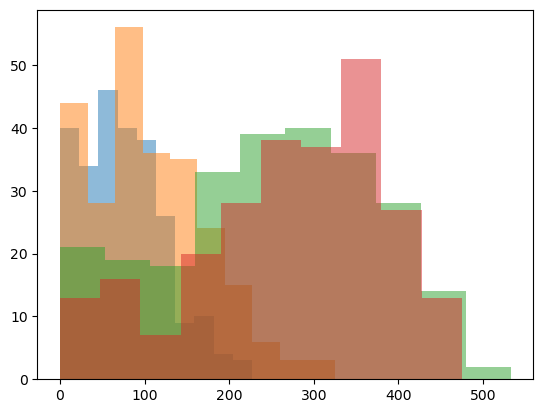

In [668]:
# Growth of number of cells in S. American by time of day. 
# Morning (blue) has flat block to 100, then a tail beyond 200 
# what if we excluded those morning-convection days (discarded them during processing)? 

#for it in range(4): 
#    plt.hist( NCELLS[0,it,:], alpha=0.5 )

# Plot results! 

Results are raw numbers of cells in each pixel, conditional on a cell being at 143,143, for each case, LST, and basetime. 

Make them into a true probability, somehow, so it can be summed rather than averaged in radius coordinate, and perhaps also that the expected-value of its log can be called information H. 

We want $p_{cell}(x,y)|cell @0,0$ 

As a probability, it should sum to 1 over.... what domain? Over x,y? That would be the probability that *a randomly selected other cell* (which always exists) is at a given location (x,y, relative time). So we simply divide results[] by its areal sum at each hour,basetime,case. But for the special case of basetime = now, we need to exclude the origin spike because we mean **a randomly selected second cell somewhere else in spacetime** of course.

In [670]:
# JUMP IN HERE FROM DISK FILE CREATED EARLIER to recover results array shaped [4,5,5,143,143], a simple integer sum 
# pcellds = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/COLDCELLS_COMPOSITESUM.nc')
# results = pcellds.pcell.values

results[0,0,0,143,143] # something like 18,000 cells at origin at a given basetime 

18894.0

In [671]:
# Create the conditional probability explained above 

condprob = results.copy() # right shaped container, initially a copy  

for icase in range(4): 
    for it1 in range(5): 
        for it2 in range(5): 
            if( it1==it2 ): 
                condprob[:,:,:,143,143] = 0  # exclude spike at origin at base time, want *other cell* condprob
                
            condprob[icase,it1,it2,:,:] /= np.sum( condprob[icase,it1,it2,:,:] )

In [672]:
# simple check 
condprob[0,4,3,:,:].sum()

1.0

In [729]:
# make coordinates (dimensions) for xarray, so we can easily use groupby_bins for all cases and times

# print( ds.lat.diff(dim='lat').mean().values )  # 0.07 degrees, 7.7777 km near the equator
x = (np.linspace(0,286,286)-143)*7.77 ### These are km units
y = (np.linspace(0,286,286)-143)*7.77
LST = np.array( range(5) )       # 3 hourly data, contrived to end at 0Z in SAmerica and 9Z in SPCZ (evening LST)
basetime = np.array( range(5) )
exp = np.array( range(4) )

In [730]:
# make xarray DataArray, and then Dataset. Write it out if desired

p_othercell = xr.DataArray(condprob, \
        coords={'exp':exp, 'basetime':basetime,'clockhour':LST, 'x': x,'y': y}, 
        dims=["exp","basetime","clockhour","x", "y"] )

p_othercell = p_othercell.to_dataset( name="spatialp_of_another_cell" )

In [731]:
p_othercell # 

<xarray.Dataset>
Dimensions:                   (exp: 4, basetime: 5, clockhour: 5, x: 286, y: 286)
Coordinates:
  * exp                       (exp) int64 0 1 2 3
  * basetime                  (basetime) int64 0 1 2 3 4
  * clockhour                 (clockhour) int64 0 1 2 3 4
  * x                         (x) float64 -1.111e+03 -1.103e+03 ... 1.111e+03
  * y                         (y) float64 -1.111e+03 -1.103e+03 ... 1.111e+03
Data variables:
    spatialp_of_another_cell  (exp, basetime, clockhour, x, y) float64 3.421e...

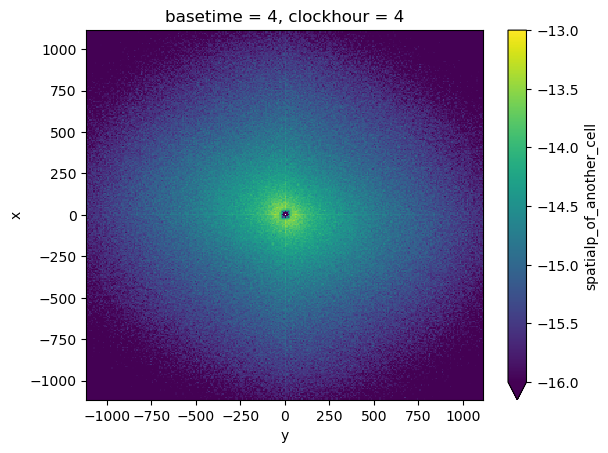

In [782]:
np.log2( sum2 ).plot( vmin=-16, vmax=-13, cmap='viridis' )


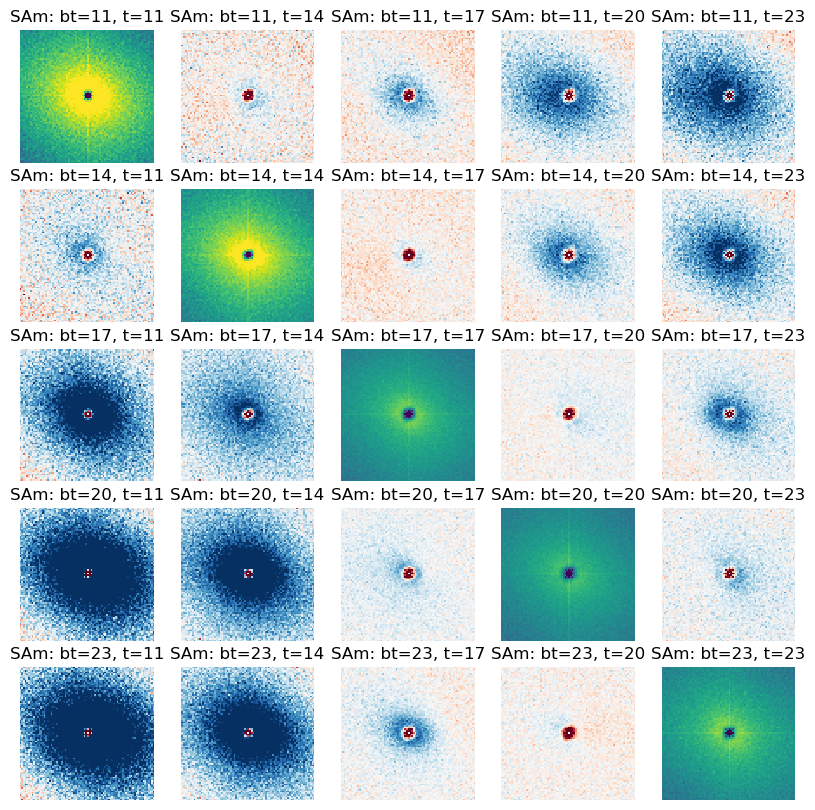

In [792]:
# logp differences (log of ratio): conditional on other t vs. unconditional at t
# S. America
# exp: 4  basetime: 5  clockhour: 5  x: 286  y: 286

plt.figure( figsize = (10,10) ) 
size = [-300,300] # km 

for icase in range(1):  # Pool the SAm and SP data
    
    for ibt in range(5): 
        for it in range(5): 
            # pooled MCS and +1year samples 
            sum1 =  p_othercell.spatialp_of_another_cell[icase  ,ibt,it,:,:] + \
                    p_othercell.spatialp_of_another_cell[icase+2,ibt,it,:,:]
            sum2 =  p_othercell.spatialp_of_another_cell[icase  ,it ,it,:,:] + \
                    p_othercell.spatialp_of_another_cell[icase+2,it ,it,:,:]
            ratio = sum1/sum2 
            
            plt.subplot(5,5,ibt*5 + it +1)
            if(ibt == it): # total probability for each clock time it 
                np.log2( sum2+1e-99 ).plot( vmin=-16, vmax=-13, cmap='viridis' , add_colorbar=False)
            else:  # conditional probability divided by total **at that it hour**
                np.log2( ratio  ).plot( vmin=-1, vmax=1, cmap='RdBu_r' , add_colorbar=False)
  
            plt.axis('off')
            plt.xlim(size); plt.ylim(size); 
            plt.title(['SAm','SPCZ'][icase] +': bt=' +str(AUTCs[ibt]) +', t=' +str(AUTCs[it]) )

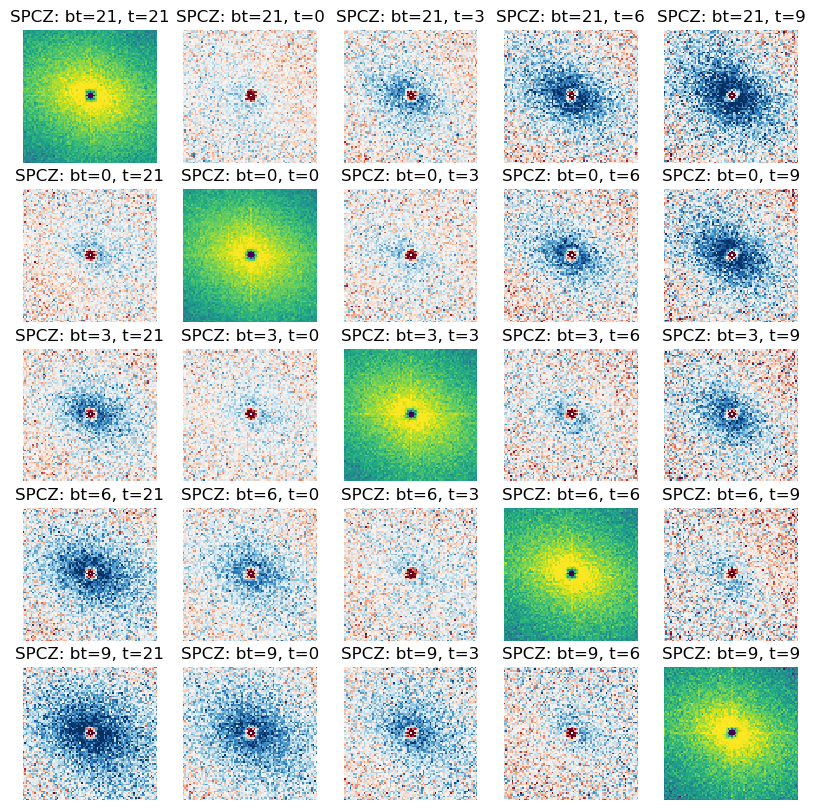

In [793]:
# logp differences (log of ratio): conditional on other t vs. unconditional at t
# SPCZ 

plt.figure( figsize = (10,10) ) 
size = [-300,300] # km 

for icase in range(1):  # Pool the SAm and SP data
    icase = 1
    for ibt in range(5): 
        for it in range(5): 
            # pooled MCS and +1year samples 
            sum1 =  p_othercell.spatialp_of_another_cell[icase  ,ibt,it,:,:] + \
                    p_othercell.spatialp_of_another_cell[icase+2,ibt,it,:,:]
            sum2 =  p_othercell.spatialp_of_another_cell[icase  ,it ,it,:,:] + \
                    p_othercell.spatialp_of_another_cell[icase+2,it ,it,:,:]
            ratio = sum1/sum2 
            
            plt.subplot(5,5,ibt*5 + it +1)
            if(ibt == it): 
                np.log2( sum2 + 1e-99 ).plot( vmin=-16, vmax=-13, cmap='viridis' , add_colorbar=False)
            else: 
                np.log2( ratio  ).plot( vmin=-1, vmax=1, cmap='RdBu_r' , add_colorbar=False)
                
            plt.axis('off')
            plt.xlim(size); plt.ylim(size); 
            plt.title(['SAm','SPCZ'][icase] +': bt=' +str(SUTCs[ibt]) +', t=' +str(SUTCs[it]) )

----------------
# Rebin to radial coordinates for plotting

In [688]:
# Rebin to a radial coordinate sysyem 
# To do this, add distance-from-center array to the xr Dataset 

xx, yy = np.meshgrid(x, y)
distance = np.sqrt( (xx-xx.mean())**2 + (yy-yy.mean())**2 )
distancex = xr.DataArray(distance, coords={'x': x,'y': y}, dims=["x", "y"] )
area = distancex*0 + (7.77*7.77) 
p_othercell['annulus_radius'] = distancex
p_othercell['area'] = area
# p_othercell.to_netcdf('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/COLDCELLS_COMPOSITE286.nc')
p_othercell

<xarray.Dataset>
Dimensions:                   (exp: 4, basetime: 5, clockhour: 5, x: 286, y: 286)
Coordinates:
  * exp                       (exp) int64 0 1 2 3
  * basetime                  (basetime) int64 0 1 2 3 4
  * clockhour                 (clockhour) int64 0 1 2 3 4
  * x                         (x) float64 0.0 7.797 ... 2.214e+03 2.222e+03
  * y                         (y) float64 0.0 7.797 ... 2.214e+03 2.222e+03
Data variables:
    spatialp_of_another_cell  (exp, basetime, clockhour, x, y) float64 3.421e...
    distance                  (x, y) float64 1.571e+03 1.566e+03 ... 1.571e+03
    area                      (x, y) float64 60.37 60.37 60.37 ... 60.37 60.37
    annulus_radius            (x, y) float64 1.571e+03 1.566e+03 ... 1.571e+03

In [693]:
# Group by distance, in bins say 15km (2 pixels) resolution. 
# Sum rather than average the probability, so its interpreation remains same 

r_bins = np.array( range(50) )*40
r_bin_labels = r_bins[1:]-20
pcell_byr = p_othercell.groupby_bins("annulus_radius", r_bins, labels=r_bin_labels).sum()

# divide by the basetime and time mean of pcell(r,t)? Too many normalizations perhaps 
# pcell_byr['pr_over_tmean'] = pcell_byr.pcell / pcell_byr.pcell.mean(dim=['basetime'])

pcell_byr

<xarray.Dataset>
Dimensions:                   (exp: 4, basetime: 5, clockhour: 5,
                               annulus_radius_bins: 49)
Coordinates:
  * exp                       (exp) int64 0 1 2 3
  * basetime                  (basetime) int64 0 1 2 3 4
  * clockhour                 (clockhour) int64 0 1 2 3 4
  * annulus_radius_bins       (annulus_radius_bins) int64 20 60 ... 1900 1940
Data variables:
    spatialp_of_another_cell  (annulus_radius_bins, exp, basetime, clockhour) float64 ...
    distance                  (annulus_radius_bins) float64 2.097e+03 ... nan
    area                      (annulus_radius_bins) float64 4.83e+03 ... nan
    annulus_radius            (annulus_radius_bins) float64 2.097e+03 ... nan

In [694]:
# Check the sums: each spatial sum should add up to 1, right? Yes it does (5x5x4 cases).
pcell_byr.spatialp_of_another_cell.sum().values

array(100.)

Text(0.5, 1.0, 'SPCZ spatialp_of_another_cell, base=PM')

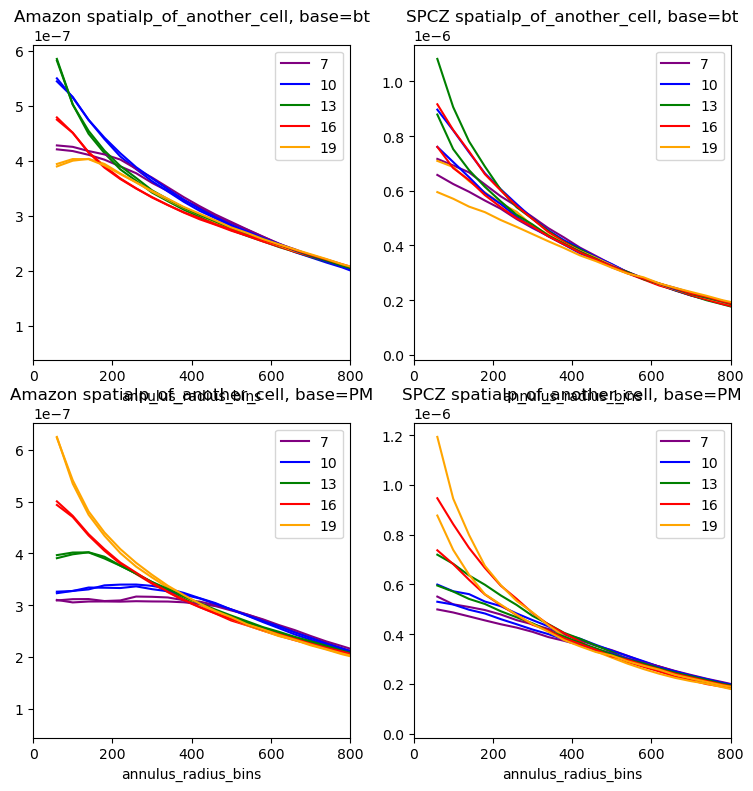

In [704]:
# Show the probability results. **Per square km.** 1e-7 type values of course.

# Here for a fixed basetime, show all other times. 
# Basetime out of 5 time levels 
bt = 2

plt.figure( figsize = (9,9) ) 

# var = 'pcell' # raw numbers 
# var = 'prob_ratio' #divided by the horizontal mean at each time of day for each exp and basetime, emphasizes r<500km 
# var = 'pr_over_tmean' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle
var = 'spatialp_of_another_cell' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle

tcolors = ['purple','blue','green','red','orange']  # predawn to ing

# Amaxon, MCS and +1y
plt.subplot(221)
for it in range(5): 
    (pcell_byr[var][1:,0,bt,it]/pcell_byr.area).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var][1:,2,bt,it]/pcell_byr.area).plot(c=tcolors[it]) #, label=AUTCs[it]) 
# one scatter plot to see the bin centers 
# pcell_byr[var] [:,2,bt,it].plot.scatter(c=tcolors[it]) #, label=AUTCs[it]) 
plt.xlim( [0,800] )
plt.legend(loc='upper right')
plt.title('Amazon '+var+', base=bt')

# SPCZ, MCS and +1y
plt.subplot(222)
for it in range(5): 
    (pcell_byr[var] [1:,1,bt,it]/pcell_byr.area).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var] [1:,3,bt,it]/pcell_byr.area).plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [0,800] )
plt.legend(loc='upper right')
plt.title('SPCZ '+var+', base=bt')


# Basetime 4: 

# Amazon, MCS and +1y
plt.subplot(223)
for it in range(5): 
    (pcell_byr[var] [1:,0,4,it]/pcell_byr.area).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var] [1:,2,4,it]/pcell_byr.area).plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [0,800] )
plt.legend(loc='upper right')
plt.title('Amazon '+var+', base=PM')

# SPCZ, MCS and +1y
plt.subplot(224)
for it in range(5): 
    (pcell_byr[var] [1:,1,4,it]/pcell_byr.area).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var] [1:,3,4,it]/pcell_byr.area).plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [0,800] )
plt.legend(loc='upper right')
plt.title('SPCZ '+var+', base=PM')

Text(0.5, 1.0, 'SPCZ spatialp_of_another_cell, base=PM')

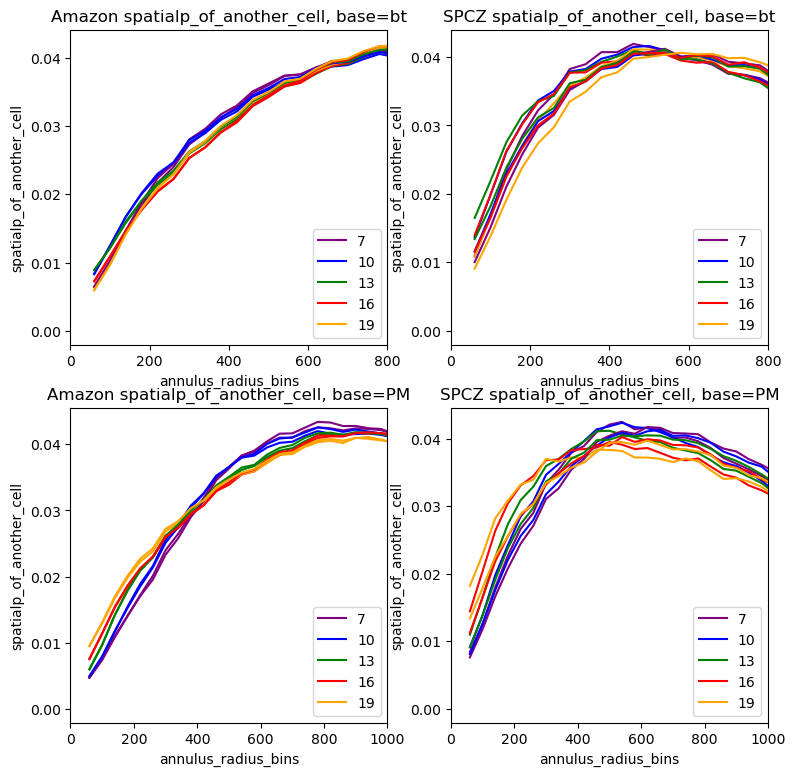

In [703]:
# Show the probability results, weighted by annulus area. SUMS TO 1 

# Here for a fixed basetime, show all other times. 
# Basetime out of 5 time levels 
bt = 2

plt.figure( figsize = (9,9) ) 

# var = 'pcell' # raw numbers 
# var = 'prob_ratio' #divided by the horizontal mean at each time of day for each exp and basetime, emphasizes r<500km 
# var = 'pr_over_tmean' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle
var = 'spatialp_of_another_cell' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle

tcolors = ['purple','blue','green','red','orange']  # predawn to evening

# Amaxon, MCS and +1y
plt.subplot(221)
for it in range(5): 
    (pcell_byr[var][1:,0,bt,it]).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var][1:,2,bt,it]).plot(c=tcolors[it]) #, label=AUTCs[it]) 
# one scatter plot to see the bin centers 
# pcell_byr[var] [:,2,bt,it].plot.scatter(c=tcolors[it]) #, label=AUTCs[it]) 
plt.xlim( [0,800] )
plt.legend(loc='lower right')
plt.title('Amazon '+var+', base=bt')

# SPCZ, MCS and +1y
plt.subplot(222)
for it in range(5): 
    (pcell_byr[var] [1:,1,bt,it]).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var] [1:,3,bt,it]).plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [0,800] )
plt.legend(loc='lower right')
plt.title('SPCZ '+var+', base=bt')


# Basetime 4: 

# Amazon, MCS and +1y
plt.subplot(223)
for it in range(5): 
    (pcell_byr[var] [1:,0,4,it]).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var] [1:,2,4,it]).plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [0,1000] )
plt.legend(loc='lower right')
plt.title('Amazon '+var+', base=PM')

# SPCZ, MCS and +1y
plt.subplot(224)
for it in range(5): 
    (pcell_byr[var] [1:,1,4,it]).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var] [1:,3,4,it]).plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [0,1000] )
plt.legend(loc='lower right')
plt.title('SPCZ '+var+', base=PM')

Text(0.5, 1.0, 'SPCZ spatialp_of_another_cell, base=now')

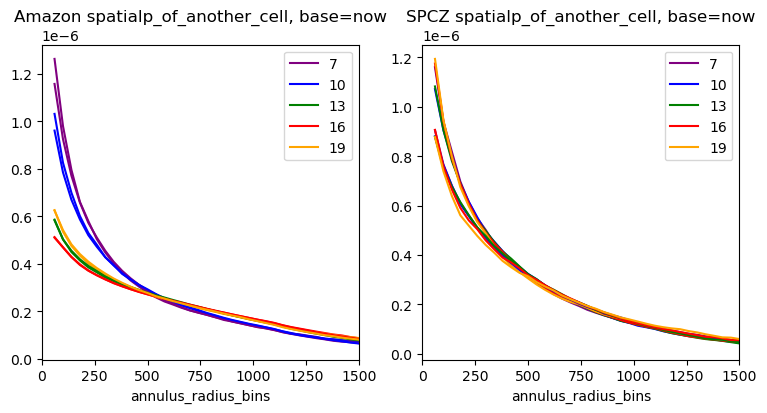

In [698]:
# INSTANTANEOUS FOR EACH BASETIME prob per unit area 
 
plt.figure( figsize = (9,9) ) 

# var = 'pcell' # raw numbers 
# var = 'prob_ratio' #divided by the horizontal mean at each time of day for each exp and basetime, emphasizes r<500km 
# var = 'pr_over_tmean' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle
var = 'spatialp_of_another_cell' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle

tcolors = ['purple','blue','green','red','orange']  # predawn to evening


# Amaxon, MCS and +1y
plt.subplot(221)
for it in range(5): 
    (pcell_byr[var][1:,0,it,it]/pcell_byr.area).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var][1:,2,it,it]/pcell_byr.area).plot(c=tcolors[it]) #, label=AUTCs[it]) 
# one scatter plot to see the bin centers 
# pcell_byr[var] [:,2,bt,it].plot.scatter(c=tcolors[it]) #, label=AUTCs[it]) 
plt.xlim( [0,1500] )
plt.legend(loc='upper right')
plt.title('Amazon '+var+', base=now')

# SPCZ, MCS and +1y
plt.subplot(222)
for it in range(5): 
    (pcell_byr[var] [1:,1,it,it]/pcell_byr.area).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var] [1:,3,it,it]/pcell_byr.area).plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [0,1500] )
plt.legend(loc='upper right')
plt.title('SPCZ '+var+', base=now')


Text(0.5, 1.0, 'SPCZ spatialp_of_another_cell, base=now')

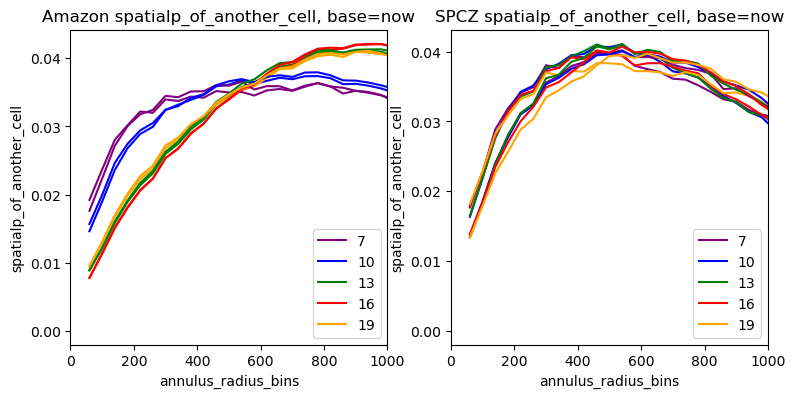

In [700]:
# INSTANTANEOUS FOR EACH BASETIME total probability (sums to 1)
 
plt.figure( figsize = (9,9) ) 

# var = 'pcell' # raw numbers 
# var = 'prob_ratio' #divided by the horizontal mean at each time of day for each exp and basetime, emphasizes r<500km 
# var = 'pr_over_tmean' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle
var = 'spatialp_of_another_cell' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle

tcolors = ['purple','blue','green','red','orange']  # predawn to evening


# Amaxon, MCS and +1y
plt.subplot(221)
for it in range(5): 
    (pcell_byr[var][1:,0,it,it]).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var][1:,2,it,it]).plot(c=tcolors[it]) #, label=AUTCs[it]) 
# one scatter plot to see the bin centers 
# pcell_byr[var] [1:,2,bt,it].plot.scatter(c=tcolors[it]) #, label=AUTCs[it]) 
plt.xlim( [0,1000] )
plt.legend(loc='lower right')
plt.title('Amazon '+var+', base=now')

# SPCZ, MCS and +1y
plt.subplot(222)
for it in range(5): 
    (pcell_byr[var] [1:,1,it,it]).plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    (pcell_byr[var] [1:,3,it,it]).plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [0,1000] )
plt.legend(loc='lower right')
plt.title('SPCZ '+var+', base=now')


In [683]:
NCELLS.sum()

531380.0

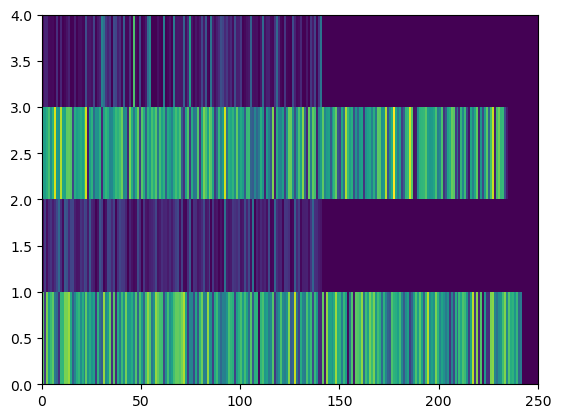

In [684]:
plt.pcolormesh( NCELLS[:,3,:] ) 

Text(0.5, 1.0, 'Kangfirmed! Wonder if CLT gurantees Gaussian for any kernel?')

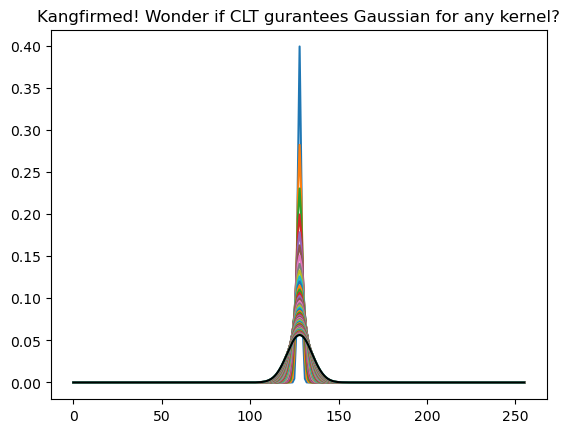

In [481]:
# Test the effect of many passes of Guassian filter. 
# because that is exactly like a local enhancement of probability near existing cells 
# applying for many generations or lifetimes of cells 

data = np.ones(256)*0
data[128] = 1
filt = data 


nfilt = 50

for i in range(nfilt): 
    filt = gaussian_filter(filt,1) 
    plt.plot( filt )

test = gaussian_filter(data, np.sqrt(nfilt) )
plt.plot(test, color='k'); plt.title('Kangfirmed! Wonder if CLT gurantees Gaussian for any kernel?')

# Assess non-uniformity as entropy difference from max

But over what domain is the probability distributed, to measure what we want to measure? 

In [ ]:
# in comes an array (treated as a histogram, p=hist/sum(hist)), out comes an entropy 
def entropy(histogram): 
    histo = histogram + 1E-99 #.fillna(1E-99) + 1E-99 # replace both 0 and nan with 1 or 2 e-99
    p = histo/np.sum(histo)   # make it into a probability that sums to 1 
    S = -np.sum( p* np.log2(p) ) 
    return S

In [ ]:
def information(histogram): 
    # just make sure it is a PDF (sums to one) 
    PDF = histogram/np.sum(histogram)

    # information subtracts a same-sized but uniform PDF, p=1/size(PDF) 
    nullPDF = 1./ np.size(PDF)

    # for log2, need to make sure the zeros are replaced with 1e-99 
    H = -np.log2(nullPDF) - (-np.sum( PDF * np.log2(PDF+1e-99)))
    Smax = -np.log2(nullPDF)
    
    return H, Smax

In [ ]:
# tests of entropy and information functions 